# Grover search: sudoku solver

In this example we are going to solve a sudoku puzzle. Since we have few qubits, we need to simplify the puzzle and so we use a 2x2 matrix where a valid solution is when in every row and every column there are no repeated values (`0` or `1`). We encode these xor-ing the values for each row and column. 
Since we want a specific solution, we add a constraint `constr`: we want the `[0][0]` element to be `True`.

We instantiate the `Grover` algorithm without value, since sudoku_check is already an oracle.

In [10]:
from qlasskit import qlassf, Qint2, Qint4, Qmatrix
from qlasskit.algorithms import Grover

@qlassf
def sudoku_check(m: Qmatrix[bool,2,2]) -> bool:
    constr = m[0][0]
    sub0 = (m[0][0] ^ m[0][1])
    sub1 = (m[1][0] ^ m[1][1])    
    sub2 = (m[0][0] ^ m[1][0])
    sub3 = (m[0][1] ^ m[1][1])
    return sub0 and sub1 and sub2 and sub3 and constr

q_algo = Grover(sudoku_check)


Now we can use our prefered framework and simulator for sampling the result; this is an example using `qiskit` with `aer_simulator`.

We obtain that the solution for this puzzle is the matrix `[[True, False], [False, True]]`.

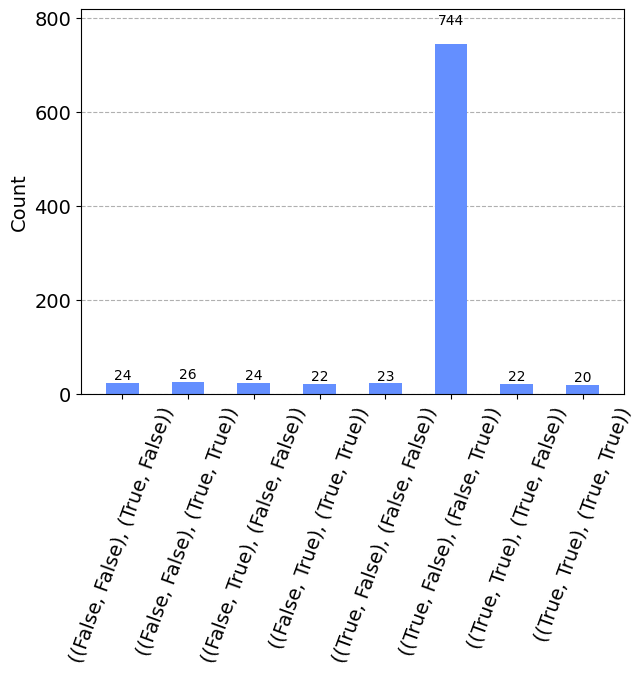

In [13]:
from qiskit import Aer, QuantumCircuit, transpile
from qiskit.visualization import plot_histogram

qc = q_algo.export('qiskit')
qc.measure_all()
simulator = Aer.get_backend("aer_simulator")
circ = transpile(qc, simulator)
result = simulator.run(circ).result()
counts = result.get_counts(circ)

counts_readable = q_algo.decode_counts(counts, discard_lower=20)
plot_histogram(counts_readable)